# Summary
要求：附件为某资金渠道过去一段时间的清算金额汇总信息，每5分钟按流入流出分别汇总输出一条交易数据(SE=流入，RE=流出)。请根据已有数据，预测该渠道7月24日至7月28日每天从当日0点到24点的流入流出轧差值（总流入-总流出），故总计需要给出5个预测数值。（注意附件中24-28日的当天10点后时间戳及数据未采集到，实际是有发生业务的。）

# 业务分析
通过历史数据1.1-7.23号的数据，进行预测7.24-7.28号的轧差值。

# 数据分析
## 1.已有的数据集：
1.1-7.23号有用全天数据，7.24-7.29号只有十点之前的数据。
根据数据情况。可以将每天的数据分成两部分，10点以前的数据以及10点以后的数据，因此可以提取下面数据特征：

1. 每天全天的轧差值：全天的流入 - 全天的流出

2. 每天10点前的轧差值： 10点前的流入 - 10点后的流出

3. 每天10点后的轧差值： 10点后的流入 - 10点后的流出 ， （若没有则为空或0）


（注意：要求预测是的24号-28号的值，但是数据集又给出了29号10点前的数据，因此后续探索过程中，看下能否把29号的数据应用上去有没有好的效果）

## 2.时间特征：
因为给出的数据是时间序列，因此可以提取出时间特征如下：

1. 星期几：根据给出的日期，计算出该日期属于星期几，并作为备选特征

2. 是否节假日：由于节假日，有可能是轧差值的一个影响因子，作为备选特征

## 3.其他特征：
由于这里的业务场景没有具体给出，暂时不考虑其他特征。

# 模型选择：
关于时间序列预测，一般我们常用简单模型的话有：arima、Holt-Winters、RNN、LSTM、GRU、prophet等。
由于时间有限，我下面可能选取2-3个模型来train，看看效果如何。如果比较差的话，就再尝试新的模型；如果还不赖，那就把主要精力放在调参上。




# 数据探索及数据预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
DataFile = "/Users/Eric/Downloads/data.csv"
df = pd.read_csv(DataFile)

dateparse = lambda dates: datetime.strptime(dates,'%Y/%m/%d %H:%M').strftime('%Y-%m-%d')

dateparse10 = lambda dates: datetime.strptime(dates,'%Y/%m/%d %H:%M').strftime('%H')

df['hour'] = df['time'].apply(dateparse10,1).astype('int')
df['time'] = df['time'].apply(dateparse,1)


df1 = df[['time', 'type', 'amount']]


df2 = df1.groupby(['time','type']).sum().reset_index()
df2['amount'] = df2.apply(lambda x: x['amount'] if x['type']=='SE' else -x['amount'], axis=1)
#计算全天的轧差值：allday_df  （其中7.24号之后的只有10点以后的）
allday_df = df2.groupby(['time']).sum()
allday_df.index = allday_df.index.to_datetime()

#计算10点前的轧差值，beforeTen_df
df1_beforeTen = df[df['hour'] < 10][['time', 'type', 'amount']]
df2_beforeTen = df1_beforeTen.groupby(['time','type']).sum().reset_index()
df2_beforeTen['amount'] = df2_beforeTen.apply(lambda x: x['amount'] if x['type']=='SE' else -x['amount'], axis=1)
beforeTen_df = df2_beforeTen.groupby(['time']).sum()
beforeTen_df.index = beforeTen_df.index.to_datetime()

#计算10点后的轧差值，afterTen_df
df1_afterTen = df[df['hour'] >= 10][['time', 'type', 'amount']]
df2_afterTen = df1_afterTen.groupby(['time','type']).sum().reset_index()
df2_afterTen['amount'] = df2_afterTen.apply(lambda x: x['amount'] if x['type']=='SE' else -x['amount'], axis=1)
afterTen_df = df2_afterTen.groupby(['time']).sum()
afterTen_df.index = afterTen_df.index.to_datetime()

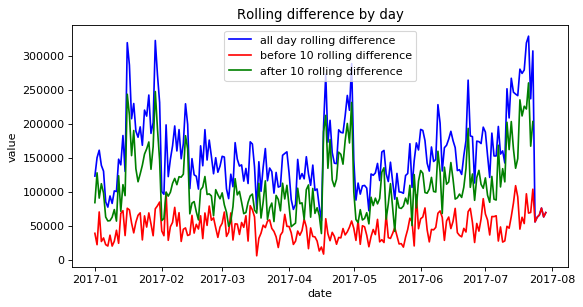

In [3]:
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(allday_df, color='blue', label='all day rolling difference')
plt.plot(beforeTen_df, color='red', label='before 10 rolling difference')
plt.plot(afterTen_df, color='green', label='after 10 rolling difference')
plt.xlabel("date")
plt.ylabel("value")
plt.title('Rolling difference by day')
plt.legend()
plt.show()

# Arima 预测模型
主要思路：
1. 获取被观测系统时间序列数据（10点之后的数据）；
2. 对数据绘图，观测是否为平稳时间序列；对于非平稳时间序列要先进行d阶差分运算，化为平稳时间序列；
3. 经过第二步处理，已经得到平稳时间序列。要对平稳时间序列分别求得其自相关系数ACF 和偏自相关系数PACF ，通过对自相关图和偏自相关图的分析，得到最佳的阶层 p 和阶数 q
4. 由以上得到的d、q、p ，得到ARIMA模型。然后开始对得到的模型进行模型检验
5. 把最后预测出来的结果（十点后的预测值） 再加上十点前的预测值。就是整天的预测值

In [4]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

## 1. 平稳性检验

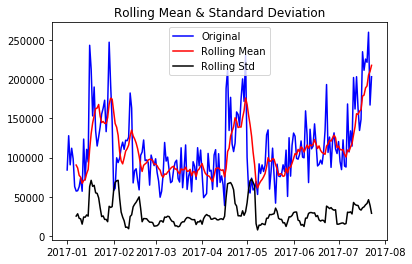

Results of Dickey-Fuller Test:
Test Statistic                  -4.041345
p-value                          0.001209
#Lags Used                       2.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [5]:
#定义平稳性检验函数
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(afterTen_df['amount'])

### 分析
-----------------------------
根据上图这里我们可以看到，十点之后的数据根据月份，波动较大，在4.5.7月中特别突出。
让数据变得不稳定的原因主要有俩：
1. 趋势（trend）-数据随着时间变化。比如说升高或者降低。
2. 季节性(seasonality)-数据在特定的时间段内变动。比如说节假日，或者活动导致数据的异常。

## 2.时序分析
### 时间序列的差分d = 1
根据下图分析比较分析，1阶差分和2阶查分都具有周期性。因此选择一阶差分就行了。

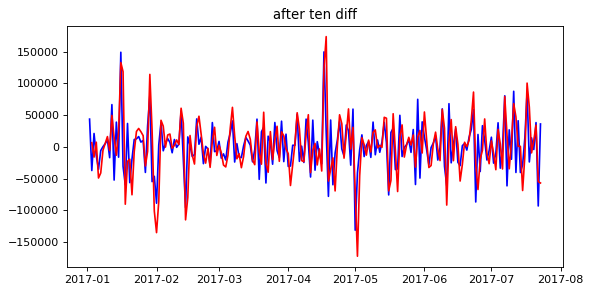

In [6]:
ts_log = afterTen_df
afterTen_diff = ts_log.diff(1)
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(afterTen_diff, color='blue' , label='diff=1')
afterTen_diff2 = ts_log.diff(2)
plt.plot(afterTen_diff2, color='red' , label='diff=2')
plt.title('after ten diff')
plt.show()

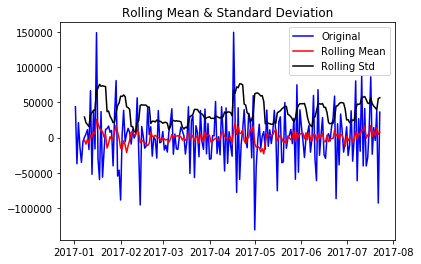

Results of Dickey-Fuller Test:
Test Statistic                -9.323705e+00
p-value                        9.737528e-16
#Lags Used                     4.000000e+00
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


In [7]:
#􀺱􁍡􀓞􁴤􀫧􀚓􀝸􁌱rolling mean 􀞾std􀞾test
afterTen_diff.dropna(inplace=True)
test_stationarity(afterTen_diff.ix[:,0])

### 分解decomposing
分解十点以后的时间序列成
trend、seasonal、residual 三部分


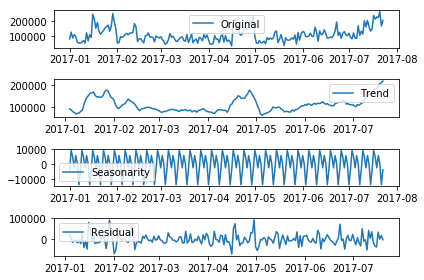

In [8]:
# 分解decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(afterTen_df['amount'])

trend = decomposition.trend  # 趋势
seasonal = decomposition.seasonal  # 季节性
residual = decomposition.resid  # 剩余的

plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonarity')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### arima中 p q 参数确定
根据ACF、PACF，确定得到q=10，p=3

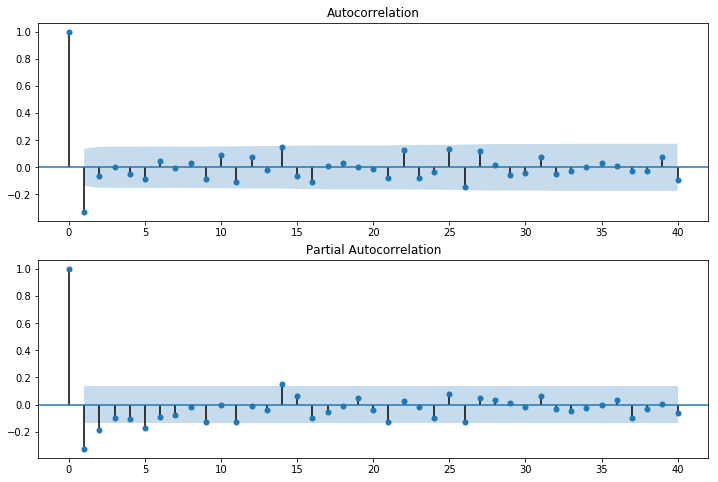

In [9]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(afterTen_diff,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(afterTen_diff,lags=40,ax=ax2)
plt.show()

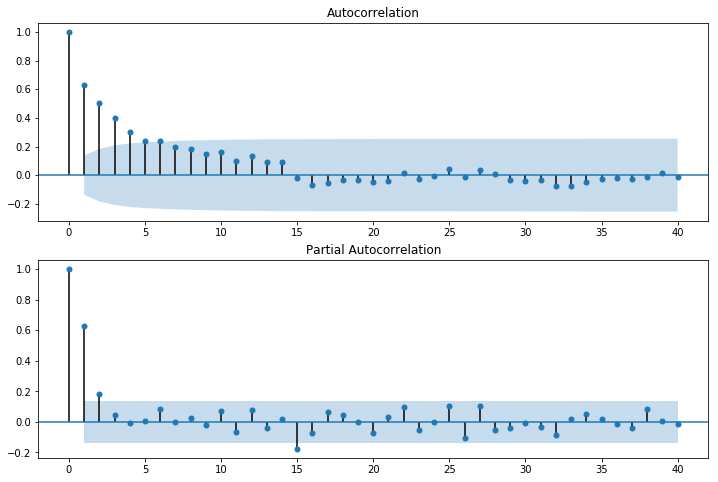

In [10]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(afterTen_df['amount'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(afterTen_df['amount'],lags=40,ax=ax2)
plt.show()

In [11]:
from statsmodels.tsa.arima_model import ARIMA
arima_model512 = ARIMA(ts_log,order=(5,1,2))
arima_model612 = ARIMA(ts_log,order=(6,1,2))
arima_model513 = ARIMA(ts_log,order=(5,1,3))
arima_model613 = ARIMA(ts_log,order=(6,1,3))

results_ARIMA512 = arima_model512.fit()
results_ARIMA612 = arima_model612.fit()
results_ARIMA513 = arima_model513.fit()
results_ARIMA613 = arima_model613.fit()

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
print("pdq = 5,1,2    AIC = " + str(results_ARIMA512.aic))
print("pdq = 6,1,2    AIC = " + str(results_ARIMA612.aic))
print("pdq = 5,1,3    AIC = " + str(results_ARIMA513.aic))
print("pdq = 6,1,3    AIC = " + str(results_ARIMA613.aic))


pdq = 5,1,2    AIC = 4830.108644824419
pdq = 6,1,2    AIC = 4831.770784351922
pdq = 5,1,3    AIC = 4829.089604547118
pdq = 6,1,3    AIC = 4833.102371749477


### 评判模型

因此选取模型pdq = 5，1，3.
检验结果表示我们的模型表现还不错

In [13]:
resid = results_ARIMA513.resid
#Q 检验
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))


            AC          Q  Prob(>Q)
lag                                
1.0  -0.000429   0.000038  0.995087
2.0  -0.004706   0.004623  0.997691
3.0   0.015999   0.057885  0.996360
4.0  -0.025745   0.196497  0.995478
5.0  -0.057854   0.899968  0.970224
6.0   0.013394   0.937863  0.987858
7.0   0.040645   1.288622  0.988741
8.0  -0.013587   1.328017  0.995209
9.0  -0.007238   1.339254  0.998173
10.0  0.014959   1.387505  0.999245
11.0 -0.016074   1.443505  0.999685
12.0  0.017854   1.512957  0.999863
13.0  0.073503   2.696279  0.998827
14.0  0.090371   4.494507  0.991680
15.0 -0.036263   4.785589  0.993791
16.0 -0.168791  11.125821  0.801653
17.0 -0.015401  11.178886  0.847115
18.0 -0.009574  11.199503  0.885700
19.0 -0.008618  11.216302  0.916348
20.0 -0.054152  11.883157  0.920039
21.0 -0.061315  12.742789  0.917366
22.0  0.076221  14.078517  0.898669
23.0 -0.068180  15.153243  0.889057
24.0 -0.015228  15.207155  0.914551
25.0  0.081207  16.748917  0.890698
26.0 -0.070713  17.924576  0

## 3.画出ARIMA模型10点之后的的预测值

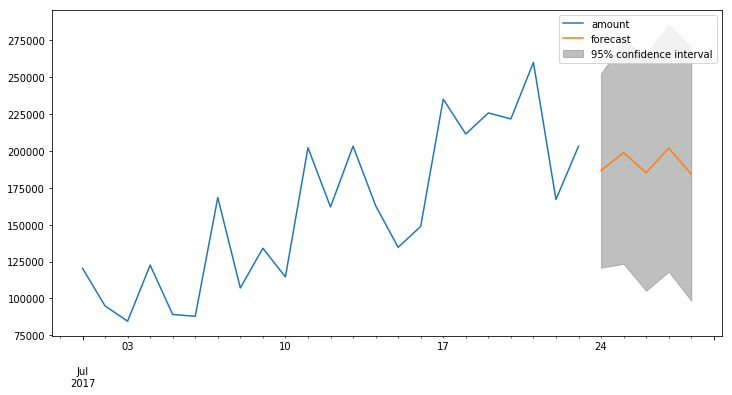

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = afterTen_df.loc['2017-07-01':].plot(ax=ax)
fig = results_ARIMA513.plot_predict('2017-07-24','2017-07-28', dynamic=True, ax=ax, plot_insample=False)

## 4.ARIMA预测结果

In [15]:
#10点之前的df
beforeTen_df0724 = beforeTen_df[(beforeTen_df.index > '2017-07-23') & (beforeTen_df.index < '2017-07-29')]
#10点之后预测的df
predict_afterTen = results_ARIMA513.predict('2017-07-24','2017-07-28',dynamic=True, typ='levels')
amount20170723  = afterTen_df[afterTen_df.index =='2017-07-23'].amount[0]
predict_afterTen_pd = pd.DataFrame(predict_afterTen, columns=beforeTen_df0724.columns)
#最终预测结果
ARIMA_PREDICT = beforeTen_df0724 + predict_afterTen_pd
ARIMA_PREDICT

,amount
2017-07-24,242483.644568
2017-07-25,261464.333340
2017-07-26,250999.263656
2017-07-27,277973.187257
2017-07-28,247348.178942


In [16]:
#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个月与i-1个月的ts_log的差值。
#由于差分化有一阶滞后，所以第一个月的数据是空的，
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print predictions_ARIMA_diff.head()
#累加现有的diff，得到每个值与第一个月的差分（同log底的情况下）。
#即predictions_ARIMA_diff_cumsum[i] 是第i个月与第1个月的ts_log的差值。
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第一个月diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure()
plt.plot(afterTen_df)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-afterTen_df['amount'])**2)/len(afterTen_df['amount'])))

NameError: name 'results_ARIMA' is not defined

# LSTM 模型
由于这里给出的特征比较少，因此，就只根据keras封装好的通用的LSTM进行预测

特征：